# Capstone Project

## Sentiment Analysis & Topic Modeling for Hotel Reviews

The project goal is to use data mining techniques to analyze hotel reviews and help the hotel to identify factors that influence guest satisfactions.

_**keyterms**: web scraping, BeautifulSoup, exploratory data analysis (EDA),  wordcloud, sentiment analysis, tf-idf, Latent Dirichlet Allocation (LDA) topic modelling, text analytics_

In [1]:
## importing packages ##
import numpy as np
import pandas as pd

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import re

from bs4 import BeautifulSoup as bs
import requests


import string
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords,wordnet 
from wordcloud import WordCloud
# nltk.download('averaged_perceptron_tagger')
# nltk.download('vader_lexicon')
# nltk.download('wordnet')

from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()


import warnings
warnings.filterwarnings("ignore")

## Part I: Scrape Reviews from Bookings.com & Clean Unstructured Text

The first step is to scrape reviews of a hotel from booking.com. The hotel we are going to analyze here is called "Hotel Beresford," which is located in San Francisco, CA.

**The scraped data includes**:
   1. Basic information of the reviewer and reviews:
       * _Rating Score_
       * _Reviewer Name_
       * _Reviewer's Nationality_
       * _Overall Review_ (contains both positive & negative reviews)
       * _Reviewer Reviewed Times_
       * _Review Date_
       * _Review Tags_ (Trip type, such as business trip, leisure trip, etc.)
   2. Positive reviews
   3. Negative reviews

In [2]:
def scrape_reviews(hotel_linkname,total_pages):
    '''
    Function to scrape hotel reviews from bookings.com
    INPUTS:
        hotel_linkname - hotel name in the bookings.com weblink
        total_pages - the total number of reviews pages to scrape
    OUTPUTS:
        reviewer_info - a dataframe that includes reviewers' basic information
        pos_reviews -  a dataframe that includes all the positive reviews 
        neg_reviews - a dataframe that includes all the negative reviews
    '''
    #Create empty lists to put in reviewers' information as well as all of the positive & negative reviews 
    info = []
    positive = []
    negative = []
    
    #bookings.com reviews link
    url = 'https://www.booking.com/reviews/us/hotel/'+ hotel_linkname +'.html?page=' 
    page_number = 1

    #Use a while loop to scrape all the pages 
    while page_number <= total_pages:

        page = requests.get(url + str(page_number)) #retrieve data from serve
        soup = bs(page.text, "html.parser") # initiate a beautifulsoup object using the html source and Python’s html.parser
        review_box = soup.find('ul',{'class':'review_list'})

        #ratings
        ratings = [i.text.strip() for i in review_box.find_all('span',{'class':'review-score-badge'})]
        
        #reviewer_info
        reviewer_info = [i.text.strip() for i in review_box.find_all('span',{'itemprop':'name'})]
        reviewer_name = reviewer_info[0::3]
        reviewer_country = reviewer_info[1::3]
        general_review = reviewer_info[2::3]

        # reviewer_review_times
        review_times = [i.text.strip() for i in review_box.find_all('div',{'class':'review_item_user_review_count'})]

        # review_date
        review_date = [i.text.strip().strip('Reviewed: ') for i in review_box.find_all('p',{'class':'review_item_date'})]

        # reviewer_tag
        reviewer_tag = [i.text.strip().replace('\n\n\n','').replace('•',',').lstrip(', ') for i 
                        in review_box.find_all('ul',{'class':'review_item_info_tags'})]

        # positive_review
        positive_review = [i.text.strip('눇').strip() for i in review_box.find_all('p',{'class':'review_pos'})]

        # negative_review
        negative_review = [i.text.strip('눉').strip() for i in review_box.find_all('p',{'class':'review_neg'})]

        # append all reviewers' info into one list
        for i in range(len(reviewer_name)):
            info.append([ratings[i],reviewer_name[i],reviewer_country[i],general_review[i], 
                         review_times[i],review_date[i],reviewer_tag[i]])

        # build positive review list
        for i in range(len(positive_review)):
            positive.append(positive_review[i])

        # build negative review list
        for i in range(len(negative_review)):
            negative.append(negative_review[i])

        # page change
        page_number +=1

    #Reviewer_info df
    reviewer_info = pd.DataFrame(info,
                        columns = ['Rating','Name','Country','Overall_review','Review_times','Review_date','Review_tags'])
    reviewer_info['Rating'] = pd.to_numeric(reviewer_info['Rating'] )
    reviewer_info['Review_times'] = pd.to_numeric(reviewer_info['Review_times'].apply(lambda x:re.findall("\d+", x)[0]))
    reviewer_info['Review_date'] = pd.to_datetime(reviewer_info['Review_date'])
    
    #positive & negative reviews dfs
    pos_reviews = pd.DataFrame(positive,columns = ['positive_reviews'])
    neg_reviews = pd.DataFrame(negative,columns = ['negative_reviews'])
    
    return reviewer_info, pos_reviews, neg_reviews

def show_data(df):
    print("The length of the dataframe is: {}".format(len(df)))
    print("Total NAs: {}".format(reviewer_info.isnull().sum().sum()))
    return df.head()

In [3]:
reviewer_info, pos_reviews, neg_reviews = scrape_reviews('beresford',total_pages = 42) #call "scrape_reviews" function

In [4]:
#reviewers' basic information
show_data(reviewer_info) 

The length of the dataframe is: 1030
Total NAs: 0


Rating     Name                   Country  \
0     8.0     Ryan            United Kingdom   
1     7.0     Myth  United States of America   
2     6.0    Mandy               New Zealand   
3     6.0  Twyford            United Kingdom   
4     8.0     Eric  United States of America   

                                      Overall_review  Review_times  \
0                                          Very Good             2   
1                            Old but great location!             2   
2  Good value for money and great for one night’s...            20   
3  Old hotel with small rooms and old decor. incl...             7   
4                                          Very Good             1   

  Review_date                                        Review_tags  
0  2020-04-27  Leisure trip, Solo traveler, Queen Room, Staye...  
1  2020-04-07  Couple, Queen Room, Stayed 1 night, Submitted ...  
2  2020-03-24  Leisure trip, Couple, Queen Room, Stayed 2 nig...  
3  2020-03-21  Leisure trip, Group, Twin Room with Two Twin B...  
4  2020-03-21  Business trip, Solo traveler, Twin Room with T...

In [5]:
#positive reviews
show_data(pos_reviews) 

The length of the dataframe is: 651
Total NAs: 0


positive_reviews
0  Location is great, short walk away Chinatown a...
1  location more than made up for being outdated ...
2                                           Location
3  Location was good in the Union square area, go...
4                                           Location

In [6]:
# positive review
show_data(neg_reviews) 

The length of the dataframe is: 614
Total NAs: 0


negative_reviews
0  Relatively basic, however it is great value fo...
1  The hotel is very dated with yellow staining o...
2  Very old water pipes which made noises during ...
3  Breakfast was rubbish.... two types of flakes ...
4                 The toilet is too low to the floor

## Part II.  Exploratory Data Analysis

### 1. Ratio of positive and negative reviews 

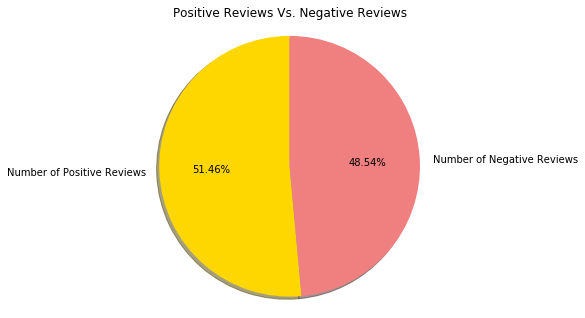

In [7]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
values = [len(pos_reviews), len(neg_reviews)]

ax.pie(values, 
       labels = ['Number of Positive Reviews', 'Number of Negative Reviews'],
       colors=['gold', 'lightcoral'],
       shadow=True,
       startangle=90, 
       autopct='%1.2f%%')
ax.axis('equal')
plt.title('Positive Reviews Vs. Negative Reviews');

The pie graph shows that the number of positive reviews is just a little bit higher than that of the negative reviews.

### 2. Rating Distribution

In [8]:
# Histogram of Ratings
print(reviewer_info['Rating'].describe())
px.histogram(reviewer_info, x="Rating", nbins=30, title = 'Histogram of Ratings')

count    1030.000000
mean        7.578544
std         1.801510
min         1.000000
25%         6.700000
50%         7.900000
75%         8.800000
max        10.000000
Name: Rating, dtype: float64


The histogram of ratings is left skewed. Most of the ratings are concentrated around 6.3 to 9.2

In [9]:
print("For all of the reviewers, they came from {} different countries.".format(reviewer_info.Country.nunique()))
print("\n")

top10_df = reviewer_info.groupby('Country').size().reset_index().sort_values(0, ascending = False).head(10)
top10_df.columns = ['Country', 'Counts']
print("Top 10 countries ranked by review counts")
top10_df

For all of the reviewers, they came from 69 different countries.


Top 10 countries ranked by review counts


Country  Counts
67  United States of America     574
1                  Australia      99
66            United Kingdom      72
8                     Canada      47
38               New Zealand      39
26                   Ireland      20
20                   Germany      10
57                     Spain      10
5                     Brazil       9
28                     Italy       7

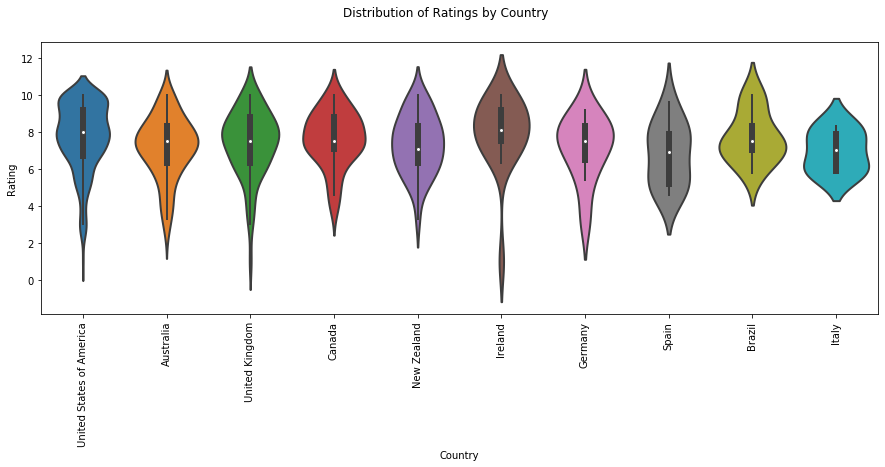

In [10]:
top10_list = top10_df['Country'].tolist()
top10 = reviewer_info[reviewer_info.Country.isin(top10_list)]

fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
ax = sns.violinplot(x = 'Country', 
                    y = 'Rating', 
                    data = top10, 
                    order = top10_list,
                    linewidth = 2) 
plt.suptitle('Distribution of Ratings by Country') 
plt.xticks(rotation=90);


People from different countries may have different standards when it comes to rating hotels and their services. Among 1030 reviewers, they came from 69 different countries. Here, we are only visualizing the distributions of the top 10 countries ranked by the number of reviews.

A Violin Plot is used to visualize the distribution of the data and its probability density. The plot shown below is displayed in the order of review counts of each country. It shows the relationship of ratings to the reviewers' country of origins. From the box plot elements, we see that the median rating given by the U.S. and Ireland reviewers are a bit higher than the rest of the reviewers from other countries, while the median rating given by the reviewers from Italy is the lowest.  Most of the shapes of the distributions (skinny on each end and wide in the middle) indicates the weights of ratings given by the reviewers are highly concentrated around the median, which is around 7 to 8. However, we probably need more data to get a better idea of the distributions.

### 3. Review Tags Counts for each Trip Type

In [11]:
#Define tag list
tag_list = ['Business','Leisure','Group','Couple','Family','friends','Solo']

#Count for each review tag
tag_counts = []
for tag in tag_list:
    counts = reviewer_info['Review_tags'].str.count(tag).sum()
    tag_counts.append(counts)

#Convert to a dataframe
trip_type = pd.DataFrame({'Trip Type':tag_list,'Counts':tag_counts}).sort_values('Counts',ascending = False)

#Visualize the trip type counts from Review_tags
fig = px.bar(trip_type, x='Trip Type', y='Counts', title='Review Tags Counts for each Trip Type')
fig.show()

A lot of the times, one review has multiple tags. The bar chart shows that most people came to San Francisco for leisure trips, either as couples or by themselves. Fewer people came with their family or with a group, and even fewer people came with friends. Out of 1030 reviews, there are only 164 reviews that were tagged "Business", which means only 16% of the reviewers came for business trips. However, we should take into account of the fact that people who came for leisure trips are usually more likely to have time or more willing to write reviews, while people who came for business trips maybe too busy or simply do not want to write any reviews. 

In [12]:
164/1029

0.15937803692905733

## Part III.  Text Analytics

### 1. Lemmatize Tokens

In [13]:
# wordnet and treebank have different tagging systems
# Create a function to define a mapping between wordnet tags and POS tags 
def get_wordnet_pos(pos_tag):

    if pos_tag.startswith('J'):
        return wordnet.ADJ 

    elif pos_tag.startswith('V'):
        return wordnet.VERB 

    elif pos_tag.startswith('N'):
        return wordnet.NOUN

    elif pos_tag.startswith('R'):
        return wordnet.ADV
    
    else:
        return wordnet.NOUN # default, return wordnet tag "NOUN"

#Create a function to lemmatize tokens in the reviews
def lemmatized_tokens(text):
        text = text.lower()
        pattern = r'\b[a-zA-Z]{3,}\b'                 
        tokens = nltk.regexp_tokenize(text, pattern) # tokenize the text
        tagged_tokens = nltk.pos_tag(tokens)  # a list of tuples (word, pos_tag)
          
        stop_words = stopwords.words('english')
        new_stopwords = ["hotel","everything","anything","nothing","thing","need",
                        "good","great","excellent","perfect","much","even","really"]  #customize extra stop_words
        stop_words.extend(new_stopwords)
        stop_words = set(stop_words)
        
        wordnet_lemmatizer = WordNetLemmatizer()
        # get lemmatized tokens                             #call function "get_wordnet_pos"
        lemmatized_words=[wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(tag)) 
                  # tagged_tokens is a list of tuples (word, tag)
                  for (word, tag) in tagged_tokens \
                  # remove stop words
                  if word not in stop_words and \
                  # remove punctuations
                  word not in string.punctuation]

        return lemmatized_words



### 2. Generate WordClouds

In [14]:
#Create a function to generate wordcloud
def wordcloud(review_df, review_colname, color, title):
    '''    
    INPUTS:
        reivew_df - dataframe, positive or negative reviews
        review_colname - column name, positive or negative review
        color - background color of worldcloud
        title - title of the wordcloud
    OUTPUT:
    Wordcloud visuazliation
    '''  
    text = review_df[review_colname].tolist()
    text_str = ' '.join(lemmatized_tokens(' '.join(text))) #call function "lemmatized_tokens"
    wordcloud = WordCloud(collocations = False,
                          background_color = color,
                          width=1600, 
                          height=800, 
                          margin=2,
                          min_font_size=20).generate(text_str)

    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.figtext(.5,.8,title,fontsize = 20, ha='center')
    
    return plt.show()     

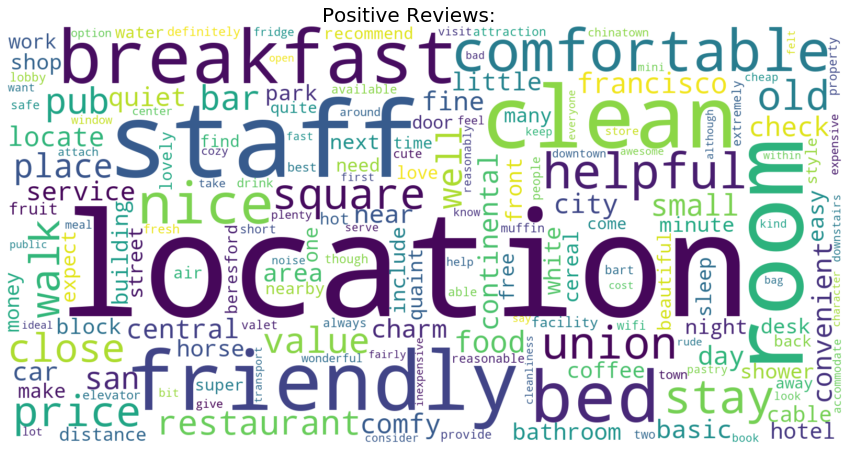

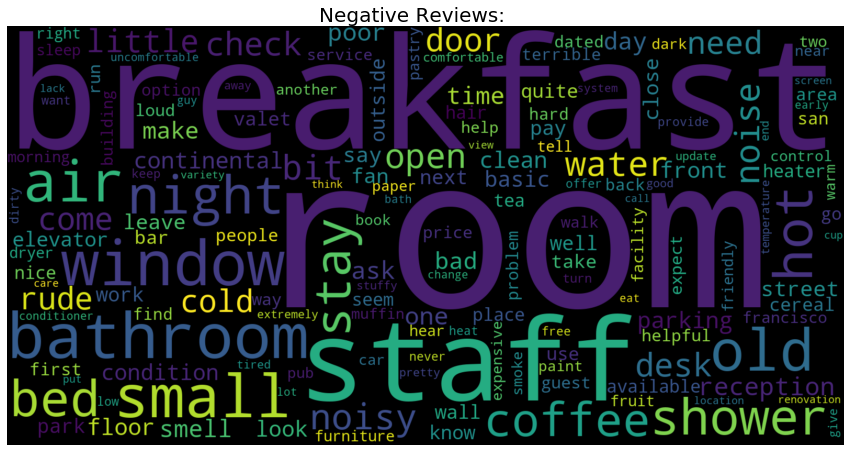

In [15]:
# Wordcoulds for Positive Reviews
wordcloud(pos_reviews,'positive_reviews', 'white','Positive Reviews: ')

# # WordCoulds for Negative Reviews
wordcloud(neg_reviews,'negative_reviews', 'black', 'Negative Reviews:')

For positive reviews, most people are probably satisfied with the location, very convenient and close to Union Square or Chinatown and easy to find restaurants or pubs nearby, friendly and helpful staff, clean room, comfortable bed, and good price, etc. The negative reviews also mentioned words like breakfast, room and staff quite often, but maybe people were complaining about the staffs who were being rude, small rooms, and coffee/ cereal/ muffin provided during breakfast. The air conditioning or the shower system may need improvements as we see words like "hot", "cold", "air", "condition", "bathroom" and "shower" in the WordCloud. The hotel may also need to solve issues related to soundproofing and parking.

### 3. Sentiment Analysis

In [16]:
#Create a function to get the subjectivity
def subjectivity(text): 
    return TextBlob(text).sentiment.subjectivity

#Create a function to get the polarity
def polarity(text): 
    return TextBlob(text).sentiment.polarity

#Create two new columns
reviewer_info['Subjectivity'] = reviewer_info['Overall_review'].apply(subjectivity)
reviewer_info['Polarity'] = reviewer_info['Overall_review'].apply(polarity)

In [17]:
#Create a function to compute the negative, neutral and positive analysis
def getAnalysis(score):
    if score <0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

reviewer_info['Analysis'] = reviewer_info['Polarity'].apply(getAnalysis)

In [18]:
# plot the polarity and subjectivity
fig = px.scatter(reviewer_info, 
                 x='Polarity', 
                 y='Subjectivity', 
                 color = 'Analysis',
                 size='Subjectivity')

#add a vertical line at x=0 for Netural Reviews
fig.update_layout(title='Sentiment Analysis',
                  shapes=[dict(type= 'line',
                               yref= 'paper', y0= 0, y1= 1, 
                               xref= 'x', x0= 0, x1= 0)])
fig.show()

The x-axis shows polarity, and y-axis shows subjectivity. Polarity tells how positive or negative the text is. The subjectivity tells how subjective or opinionated the text is. The green dots lies on the vertical line are the "neutral" reviews, the red dots on the left are the "negative" reviews, and the blue dots on the right are the "positive" reviews. Bigger dots indicate more subjectivity. We see that positive reviews are more than the negatives.

### 4. LDA Topic Modelling

We apply the LDA model to find each document topic distribution and the high probability of word in each topic. Here, we want to specifically look at the **negative reviews** to find out what aspects should the hotel be focusing on improving. 

#### Steps to find the optimal LDA model:

**1. Convert the reviews to document-term matrix**
> `TF` computes the classic number of times the word appears in the text, and `IDF` computes the relative importance of this word which depends on how many texts the word can be found. `TF-DF` is the inverse document frequency. It adjusts for the fact that some words appear more frequently in general, like "we", "the", etc. We discard words that appeared in > 90% of the reviews and words appeared in < 10 reviews since high appearing words are too common to be meaningful in topics and low appearing words won’t have a strong enough signal and might even introduce noise to our model.


**2. GridSearch and tune for the optimal LDA model**
> The process of grid search can consume a lot of time because it constructs multiple LDA models for all possible combinations of param values in the param_grid dict. So, here we are only tuning two parameters: (1)n_components (number of topics) and (2)learning_decay (which controls the learning rate).


**3. Output the optimal lda model and its parameters**
> Here we can diagnose model performance with perplexity and log-likelihood scores. Higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. However, perplexity might not be the best measure to evaluate topic models because it doesn’t consider the context and semantic associations between words.
    
    
**4. Compare LDA Model Performance Scores**
> Here, we have a line plot to show the LDA model performance scores of with different params

In [19]:
#Create a function to build the optimal LDA model
def optimal_lda_model(df_review, review_colname):
    '''
    INPUTS:
        df_review - dataframe that contains the reviews
        review_colname: name of column that contains reviews
        
    OUTPUTS:
        lda_tfidf - Latent Dirichlet Allocation (LDA) model
        dtm_tfidf - document-term matrix in the tfidf format
        tfidf_vectorizer - word frequency in the reviews
        A graph comparing LDA Model Performance Scores with different params
    '''
    docs_raw = df_review[review_colname].tolist()

    #************   Step 1: Convert to document-term matrix   ************#

    #Transform text to vector form using the vectorizer object 
    tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                    stop_words = 'english',
                                    lowercase = True,
                                    token_pattern = r'\b[a-zA-Z]{3,}\b', # num chars > 3 to avoid some meaningless words
                                    max_df = 0.9,                        # discard words that appear in > 90% of the reviews
                                    min_df = 10)                         # discard words that appear in < 10 reviews    

    #apply transformation
    tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())

    #convert to document-term matrix
    dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)  

    print("The shape of the tfidf is {}, meaning that there are {} {} and {} tokens made through the filtering process.".\
              format(dtm_tfidf.shape,dtm_tfidf.shape[0], review_colname, dtm_tfidf.shape[1]))

    
    #*******   Step 2: GridSearch & parameter tuning to find the optimal LDA model   *******#

    # Define Search Param
    search_params = {'n_components': [5, 10, 15, 20, 25, 30], 
                     'learning_decay': [.5, .7, .9]}

    # Init the Model
    lda = LatentDirichletAllocation()

    # Init Grid Search Class
    model = GridSearchCV(lda, param_grid=search_params)

    # Do the Grid Search
    model.fit(dtm_tfidf)


    #*****  Step 3: Output the optimal lda model and its parameters  *****#

    # Best Model
    best_lda_model = model.best_estimator_

    # Model Parameters
    print("Best Model's Params: ", model.best_params_)

    # Log Likelihood Score: Higher the better
    print("Model Log Likelihood Score: ", model.best_score_)

    # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
    print("Model Perplexity: ", best_lda_model.perplexity(dtm_tfidf))


    #***********   Step 4: Compare LDA Model Performance Scores   ***********#

    #Get Log Likelyhoods from Grid Search Output
    gscore=model.fit(dtm_tfidf).cv_results_
    n_topics = [5, 10, 15, 20, 25, 30]

    log_likelyhoods_5 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.5]
    log_likelyhoods_7 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.7]
    log_likelyhoods_9 = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==0.9]

    # Show graph
    plt.figure(figsize=(12, 8))
    plt.plot(n_topics, log_likelyhoods_5, label='0.5')
    plt.plot(n_topics, log_likelyhoods_7, label='0.7')
    plt.plot(n_topics, log_likelyhoods_9, label='0.9')
    plt.title("Choosing Optimal LDA Model")
    plt.xlabel("Num Topics")
    plt.ylabel("Log Likelyhood Scores")
    plt.legend(title='Learning decay', loc='best')
    plt.show()
    
    return best_lda_model, dtm_tfidf, tfidf_vectorizer

The shape of the tfidf is (614, 138), meaning that there are 614 negative_reviews and 138 tokens made through the filtering process.
Best Model's Params:  {'learning_decay': 0.7, 'n_components': 5}
Model Log Likelihood Score:  -2721.182716398506
Model Perplexity:  309.66184392394905


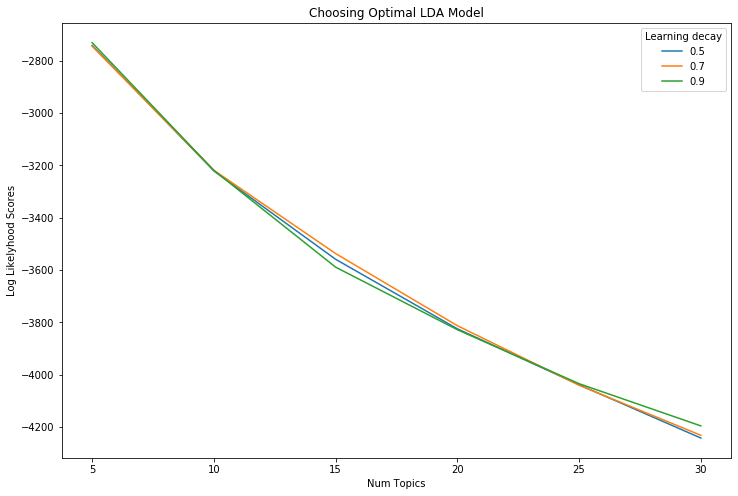

In [20]:
best_lda_model, dtm_tfidf, tfidf_vectorizer = optimal_lda_model(neg_reviews, 'negative_reviews')

In [21]:
#Create a function to inspect the topics we created 
def display_topics(model, feature_names, n_top_words):
    '''
    INPUTS:
        model - the model we created
        feature_names - tells us what word each column in the matric represents
        n_top_words - number of top words to display

    OUTPUTS:
        a dataframe that contains the topics we created and the weights of each token
    '''
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx+1)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx+1)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)


display_topics(best_lda_model, tfidf_vectorizer.get_feature_names(), n_top_words = 20) 

Topic 1 words Topic 1 weights Topic 2 words Topic 2 weights Topic 3 words  \
0            air            16.6     breakfast            30.7         staff   
1          small            13.6          room            22.1     breakfast   
2   conditioning            12.3           hot            17.1          poor   
3          noise            10.5        coffee            14.9         basic   
4           room             9.8         water            12.7         needs   
5          rooms             9.7        shower            10.8        really   
6           didn             8.4      bathroom             7.7          room   
7           loud             8.2          door             7.0          rude   
8           work             7.3          need             6.8           old   
9          great             6.4       limited             6.6         small   
10          like             6.0      elevator             6.6      bathroom   
11           did             4.4           tea             6.2        cereal   
12        guests             4.0          cold             6.0          desk   
13       outside             4.0     reception             5.9         hotel   
14        window             3.8   conditioner             5.7         smell   
15           don             3.5           fan             5.5      friendly   
16       windows             3.2        window             5.1          dark   
17          left             3.1      expected             4.8         fruit   
18       morning             3.1          hard             4.8          just   
19          wall             2.6     extremely             4.5           bad   

   Topic 3 weights  Topic 4 words Topic 4 weights Topic 5 words  \
0             22.0        parking            15.3     breakfast   
1             12.6          noisy            14.1          good   
2             11.8           room            13.6        little   
3             11.8          hotel            11.9           bit   
4             11.4            bed            10.7         dated   
5             11.3          night             8.3         hotel   
6              9.9          valet             8.2   continental   
7              9.0        variety             7.3        better   
8              9.0            got             6.8         quite   
9              8.9           stay             6.7         floor   
10             7.7      expensive             6.4         tired   
11             7.3        service             6.4          hair   
12             7.0            old             6.4          beds   
13             6.7  uncomfortable             5.8          room   
14             6.6         window             5.8           san   
15             6.1            did             5.6     available   
16             6.1         people             5.5         dryer   
17             5.6           desk             5.5     francisco   
18             5.5           near             5.4          wasn   
19             5.4          staff             5.4      location   

   Topic 5 weights  
0             14.0  
1             13.2  
2             13.1  
3             11.8  
4              9.8  
5              8.6  
6              8.2  
7              7.7  
8              7.3  
9              7.1  
10             7.0  
11             6.9  
12             6.3  
13             6.2  
14             6.1  
15             5.9  
16             5.8  
17             5.5  
18             5.1  
19             4.4

**Visualize the topics with pyLDAVis Visualization**

pyLDAVis is designed to help better understand and interpret individual topics and the relationships between the topics. A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant. 
 
On the left-hand side of the visualization, each topic is represented by a bubble. The larger the bubble, the more prevalent is that topic. The indices inside the circle indicates the sorted order by the area with the number 1 being the most popular topic, and number 5 being the least popular topic. The distance between two circles represents the topic similarity. However, this is just an approximation to the original topic similarity matrix because we are only using a two-dimensional scatter plots to best represent the spatial distribution of all 5 topics. 

The right-hand side shows the top-30 most relevant terms for the topic you select on the left. The blue bar represents the overall term frequency, and the red bar indicates the estimated term frequency within the selected topic. So, if you see a bar with both red and blue, it means the term also appears at other topics. You can hover over the term to see in which topic(s) is the term also included. 

You can adjust the relevance metric (λ) by sliding the bar on the top right corner. It helps to strike a balance between the terms that are exclusively popular for the topic you selected when λ=0 or choosing words that also appears more in other topics as you slide the λ to the right.

In [22]:
# Topic Modelling Visualization for the Negative Reviews
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tfidf, tfidf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.017473  0.003390       1        1  24.502526
1      0.100712 -0.150801       2        1  20.584604
4     -0.164395  0.151050       3        1  19.656825
2     -0.137775 -0.126273       4        1  19.593489
0      0.183985  0.122634       5        1  15.662556, topic_info=    Category       Freq          Term      Total  loglift  logprob
0    Default  19.000000           air  19.000000  30.0000  30.0000
114  Default  25.000000         staff  25.000000  29.0000  29.0000
14   Default  55.000000     breakfast  55.000000  28.0000  28.0000
112  Default  23.000000         small  23.000000  27.0000  27.0000
28   Default  12.000000  conditioning  12.000000  26.0000  26.0000
..       ...        ...           ...        ...      ...      ...
11    Topic5   1.904542          beds   8.173829   0.3972  -4.6161
104   Topic5   9.485403          room  55.365270   0.0897  -3.0106
48    Topic5   1.560890         floor   9.502980   0.0475  -4.8151
9     Topic5   1.911697      bathroom  18.921575  -0.4384  -4.6124
79    Topic5   1.623884          need  12.110241  -0.1553  -4.7756

[208 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         2  0.152220      air
0         5  0.811838      air
1         1  0.376877     area
1         4  0.565315     area
2         1  0.493268      ask
...     ...       ...      ...
135       5  0.277172   window
136       1  0.267088  windows
136       3  0.267088  windows
136       5  0.400632  windows
137       5  0.904004     work

[284 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 5, 3, 1])

## Conclusion

From the Sentiment Analysis scatter plot, we see that positive reviews are slightly more than the negatives. Hotel Beresford definitely needs to improve hotel guest satisfaction. 

The WordCloud reveals some problems for the hotel manager to look into, like their breakfast. However, it is probably necessary to read detail reviews about their breakfast to figure out what exactly needs to be improved, maybe coffee or pastries as appeared in the WordCloud. Also, the hotel manager should train staff well to provide friendlier and better services. The hotel may also need to work with issues related to soundproofing, air conditioning, shower system and parking. 

The EDA section could give the hotel manager a general idea of the reviews as well as the rating distribution. The pyLDAvis interactive visualization would help the hotel manager to further understand what most popular topics within the negative reviews are and make improvements accordingly.